In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import SAGEConv
from dgl.nn.pytorch import GraphConv,GATConv,ChebConv,NNConv
import numpy as np
import dask.diagnostics
import fsspec
import xarray as xr
from dgl.nn.pytorch.factory import KNNGraph
import matplotlib.pyplot as plt
import networkx as nx
import os
from torch.utils.data import DataLoader
import torch.optim as optim
import warnings
import time
import select as sl
import pickle
import fv3viz
from load_data import *
from utils import *
# from Newmodel import *
from sklearn.preprocessing import StandardScaler
from SAGEUnetModel import UnetGraphSAGE



/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# weightFile="gs://vcm-ml-experiments/full-model-emulation/2022-07-23/weight_layer_TAAAAAATAAAAAAT_lag1_lead1_window24_epochs_20"
# weightFile="full-model-emulation_2022-07-23_weight_layer_TAAAAAATTAAAAAAT_lag4_lead4_window96_epochs_20"
# weightFile="full-model-emulation_2022-07-24_weight_layer_SAGEUnet_lead6_epochs_20MP_Block_4"
weightFile='full-model-emulation_2022-08-04_weight_layer_SAGEUnet_WithNewLayers_lead6_epochs_30MP_Block_1aggregat_poolcoarsen_3residual_0'

gaprhFile='UpdatedGraph_Neighbour10_Coarsen3'
residual=0
num_step=1
coarsenInd=3
aggregator='pool'

Press=0
nameModel='SAGEUnet' # 'SAGEUnet' 'SpatioTemp' #'MPGNN' #'Atten' #'GCN' 'MPGNN'
savename='SAGEUnetlead6_block8_ep40'




lead=6
lead2=6
day=1
window=6*day


pred_len=1
num_heads=2

StartSlice=9000
EndSlice=10000


if lead==1:
    dayInter=24
elif lead==6:
     dayInter=4   
elif lead==4:
     dayInter=6    

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lr=0.001
disablecuda ='store_true'
batch_size=10
epochs=5

control_str='TAAAAAATTAAAAAAT'#'TNSTTNST' #'TNTSTNTST'
channels=[7, 16, 32, 64, 32, 128]
drop_prob = 0
out_feat=2

In [4]:

if Press==1:
    

    variableList=['h500','PRESsfc']

    Zmean=5765.8457   #Z500mean=5765.8457, 
    Zstd=90.79599   #Z500std=90.79599

    Tmean=98683.26     #SurfPressmean=98683.26
    Tstd=6049.9487     #SurfPressstd=6049.9487
    
    data_url1 = "gs://vcm-ml-scratch/ebrahimn/2022-07-02/experiment-5-y/fv3gfs_run/"
    state_testing_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'atmos_dt_atmos.zarr')))

    Z500test=state_testing_data[variableList[0]].isel(time=slice(StartSlice,EndSlice))
    T2mtest=state_testing_data[variableList[1]].isel(time=slice(StartSlice,EndSlice))

    Z500test=np.swapaxes(Z500test.values, 1, 0)
    T2mtest=np.swapaxes(T2mtest.values, 1, 0)

    Z500test=Z500test.reshape(np.size(Z500test, 0), np.size(Z500test, 1)*np.size(Z500test, 2)*np.size(Z500test, 3))
    T2mtest=T2mtest.reshape(np.size(T2mtest, 0), np.size(T2mtest, 1)*np.size(T2mtest, 2)*np.size(T2mtest, 3))

    T2mtest=(T2mtest-Tmean)/Tstd
    Z500test=(Z500test-Zmean)/Zstd


    # Z500test=np.swapaxes(Z500test, 1, 0)
    # T2mtest=np.swapaxes(T2mtest, 1, 0)

elif Press==0:


    variableList=['h500','h200','h850']

    Zmean=5765.8457   #Z500mean=5765.8457, 
    Zstd=90.79599   #Z500std=90.79599

    Tmean=10643.382          #Thickmean=10643.382
    Tstd=162.12427              #Thickstd=162.12427

    data_url1 = "gs://vcm-ml-scratch/ebrahimn/2022-07-02/experiment-5-y/fv3gfs_run/"
    state_testing_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'atmos_dt_atmos.zarr')))

    Z500test=state_testing_data[variableList[0]].isel(time=slice(StartSlice,EndSlice)).coarsen(grid_yt=coarsenInd).mean().coarsen(grid_xt=coarsenInd).mean()
    T2mtest1=state_testing_data[variableList[1]].isel(time=slice(StartSlice,EndSlice)).coarsen(grid_yt=coarsenInd).mean().coarsen(grid_xt=coarsenInd).mean()
    T2mtest2=state_testing_data[variableList[2]].isel(time=slice(StartSlice,EndSlice)).coarsen(grid_yt=coarsenInd).mean().coarsen(grid_xt=coarsenInd).mean()

    Z500test=np.swapaxes(Z500test.values, 1, 0)
    T2mtest1=np.swapaxes(T2mtest1.values, 1, 0)
    T2mtest2=np.swapaxes(T2mtest2.values, 1, 0)

    T2mtest=T2mtest1-T2mtest2

    Z500test=Z500test.reshape(np.size(Z500test, 0), np.size(Z500test, 1)*np.size(Z500test, 2)*np.size(Z500test, 3))
    T2mtest=T2mtest.reshape(np.size(T2mtest, 0), np.size(T2mtest, 1)*np.size(T2mtest, 2)*np.size(T2mtest, 3))

    T2mtest=(T2mtest-Tmean)/Tstd
    Z500test=(Z500test-Zmean)/Zstd


    # Z500test=np.swapaxes(Z500test, 1, 0)
    # T2mtest=np.swapaxes(T2mtest, 1, 0)

In [5]:
lat_lon_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'state_after_timestep.zarr')))
lat1=(lat_lon_data.latitude[1,:,::coarsenInd,::coarsenInd].load())
lon1=(lat_lon_data.longitude[1,:,::coarsenInd,::coarsenInd].load())
lat=lat1.values.flatten()
lon=lon1.values.flatten()
len(lon)

landSea= xr.open_zarr(fsspec.get_mapper("gs://vcm-ml-experiments/default/2022-05-09/baseline-35day-spec-sst/fv3gfs_run/state_after_timestep.zarr"))
landSea_Mask=(landSea.land_sea_mask[1].load())
landSea_Mask = landSea_Mask[:,::coarsenInd,::coarsenInd].values.flatten()

num_nodes=len(lon)
print(f"numebr of grids: {num_nodes}")

cosLat=np.cos(lat)
cosLon=np.cos(lon)
sinLat=np.sin(lat)
sinLon=np.sin(lon)
if nameModel=='SpatioTemp': 
    for i in range(3):
            if i==0:
                sinLon=torch.tensor(sinLon).unsqueeze(0).repeat(int(window/lead),1)
                cosLon=torch.tensor(cosLon).unsqueeze(0).repeat(int(window/lead),1)
                sinLat=torch.tensor(sinLat).unsqueeze(0).repeat(int(window/lead),1)
                cosLat=torch.tensor(cosLat).unsqueeze(0).repeat(int(window/lead),1)
                landSea_Mask=torch.tensor(landSea_Mask).unsqueeze(0).repeat(int(window/lead),1)
            elif i==1:
                sinLon=(sinLon).unsqueeze(0).repeat(1,1,1)
                cosLon=(cosLon).unsqueeze(0).repeat(1,1,1)
                sinLat=(sinLat).unsqueeze(0).repeat(1,1,1)
                cosLat=(cosLat).unsqueeze(0).repeat(1,1,1)
                landSea_Mask=(landSea_Mask).unsqueeze(0).repeat(1,1,1)

            elif i==2:
                sinLon=(sinLon).unsqueeze(0).repeat(1,1,1,1)
                cosLon=(cosLon).unsqueeze(0).repeat(1,1,1,1)
                sinLat=(sinLat).unsqueeze(0).repeat(1,1,1,1)
                cosLat=(cosLat).unsqueeze(0).repeat(1,1,1,1)
                landSea_Mask=(landSea_Mask).unsqueeze(0).repeat(1,1,1,1)

    exteraVar=torch.cat((sinLon, sinLat,cosLon,cosLat,landSea_Mask), 1)

else:

    for i in range(2):
        if i==0:
            sinLon=torch.tensor(sinLon).unsqueeze(0).repeat(1,1)
            cosLon=torch.tensor(cosLon).unsqueeze(0).repeat(1,1)
            sinLat=torch.tensor(sinLat).unsqueeze(0).repeat(1,1)
            cosLat=torch.tensor(cosLat).unsqueeze(0).repeat(1,1)
            landSea_Mask=torch.tensor(landSea_Mask).unsqueeze(0).repeat(1,1)
        elif i==1:
            sinLon=(sinLon).unsqueeze(0).repeat(1,1,1)
            cosLon=(cosLon).unsqueeze(0).repeat(1,1,1)
            sinLat=(sinLat).unsqueeze(0).repeat(1,1,1)
            cosLat=(cosLat).unsqueeze(0).repeat(1,1,1)
            landSea_Mask=(landSea_Mask).unsqueeze(0).repeat(1,1,1)
            exteraVar=torch.cat((sinLon, sinLat,cosLon,cosLat,landSea_Mask), 1).to(device)
            exteraVar=np.swapaxes(exteraVar,2, 1)

g = pickle.load(open(gaprhFile, 'rb'))

numebr of grids: 1536


In [6]:
exteraVar.shape

torch.Size([1, 1536, 5])

In [7]:
Z500test=np.expand_dims(Z500test,axis=0)
T2mtest=np.expand_dims(T2mtest,axis=0)
dataSets=np.concatenate((Z500test,T2mtest),axis=0)
del Z500test, T2mtest

In [8]:
np.shape(dataSets)

(2, 1000, 1536)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = g.to(device)

if nameModel=='SpatioTemp':
    print(nameModel)
    x_t=np.zeros([2,int(window/lead),num_nodes])
    y_t=np.zeros([2,np.size(dataSets,1)-window,num_nodes])
    x_t[:, :, :] = dataSets[:,0:int(window):lead,:].reshape(2, int(window/lead), num_nodes)
    y_t=dataSets[:,int(window)-lead+(lead2*pred_len)::lead2,:]

# y_t=dataSets[:,int(window/lead)::lead,:]
    x_t=np.expand_dims(x_t,axis=0)
    x_t=torch.tensor(x_t)
    y_t=torch.tensor(y_t)
    net = STGCN_WAVE(channels, int(window/lead), out_feat, num_nodes, g, drop_prob, device, num_heads, control_str).to(device)
    net.load_state_dict(torch.load(weightFile+'.pt',map_location=torch.device('cpu')))
    net.to(device)
    net.eval()
    
    M=np.size(y_t,1)

    rmse_Z=np.zeros([int(M)])

    autoreg_pred = torch.zeros([M,2,len(lon)])
    with torch.no_grad():
        for i in range(M):
            x=torch.cat((x_t, exteraVar), 1).float()
            y_pred = net(x).view(len(x), out_feat, -1)
            autoreg_pred[i,:,:]=y_pred.squeeze()
            y_pred=y_pred.unsqueeze(2)
            x_t[:,:,0:-1]=x_t[:,:,1::]
            x_t[:,:,int(window/lead)-1,:]=y_pred[0,:,0,:]
            rmse_Z[i]=torch.square(torch.mean((autoreg_pred[i,0,:]-y_t[0,i,:])**2))
            # evaluate_metric(y_pred)
            if i%24==0:
                print("day: ",int(i/24))

elif nameModel=='SAGEUnet':
    print(nameModel)
    x_t=dataSets[:,0,:]
    y_t=dataSets[:,lead::lead,:]
    x_t=np.expand_dims(x_t,axis=0)
    x_t=torch.tensor(x_t)
    y_t=torch.tensor(y_t)

    x_t=np.swapaxes(x_t, 2, 1)
    y_t=np.swapaxes(y_t, 2, 1)
    y_t=torch.Tensor(y_t).to(device)
    y_t=torch.Tensor(y_t).to(device)

    net = UnetGraphSAGE(g,7,256, 2,num_step,aggregator).to(device)
    net.load_state_dict(torch.load(weightFile+'.pt',map_location=torch.device('cpu')))
    net.to(device)
    net.eval()

    M=np.size(y_t,2)

    rmse_Z=np.zeros([int(M)])

    autoreg_pred = torch.zeros([M,len(lon),2])
    with torch.no_grad():
        for i in range(M):
            exteraVar1=exteraVar[:x_t.size(0)]
            x=torch.squeeze(torch.cat((x_t, exteraVar1), 2)).float() 
            y_pred = net(x,exteraVar1).view(-1 ,out_feat)
            if residual==1:
                if i==0:
                    autoreg_pred[i,:,:]=x_t[0,:,:]+y_pred.squeeze()
                    x_t=autoreg_pred[[i],:,:]
                else:
                    autoreg_pred[i,:,:]=autoreg_pred[i-1,:,:]+y_pred.squeeze()
                    x_t=autoreg_pred[[i],:,:]
            elif residual==0:
                autoreg_pred[i,:,:]=y_pred.squeeze()
                x_t=autoreg_pred[[i],:,:]

            rmse_Z[i]=torch.square(torch.mean((autoreg_pred[i,:,0]-y_t[0,:,i])**2))
            # evaluate_metric(y_pred)
            if i%24==0:
                print("day: ",int(i/24))
    y_t=np.swapaxes(y_t, 2, 1)
    autoreg_pred=np.swapaxes(autoreg_pred, 2, 1)


SAGEUnet
day:  0
day:  1
day:  2
day:  3
day:  4
day:  5
day:  6


In [ ]:
"""
    run for tendency calculation
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = g.to(device)

if nameModel=='SpatioTemp':
    print(nameModel)

elif nameModel=='SAGEUnet':
    print(nameModel)
   

    net = UnetGraphSAGE(g,7,256, 2,num_step,aggregator).to(device)
    net.load_state_dict(torch.load(weightFile+'.pt',map_location=torch.device('cpu')))
    net.to(device)
    net.eval()

    M=10

    rmse_Z=np.zeros([int(M)])

    autoreg_pred = torch.zeros([M,len(lon),2])
    tend_predict= torch.zeros([M,len(lon),2])
    tend_truth= torch.zeros([M,len(lon),2])

    with torch.no_grad():
        for i in range(M):
            x_t=dataSets[:,i,:]
            y_t=dataSets[:,lead+i::lead,:]
            x_t=np.expand_dims(x_t,axis=0)
            x_t=torch.tensor(x_t)
            y_t=torch.tensor(y_t)

            x_t=np.swapaxes(x_t, 2, 1)
            y_t=np.swapaxes(y_t, 2, 1)
            y_t=torch.Tensor(y_t).to(device)
            y_t=torch.Tensor(y_t).to(device)

            exteraVar1=exteraVar[:x_t.size(0)]
            x=torch.squeeze(torch.cat((x_t, exteraVar1), 2)).float() 
            y_pred = net(x,exteraVar1).view(-1 ,out_feat)
            tend_predict[i]=y_pred.squeeze()-x_t[0,:,:]
            tend_truth[i]=np.swapaxes(y_t[:,:,0],1,0)-x_t[0,:,:]
            print("Tend day: ",int(i))
    y_t=np.swapaxes(y_t, 2, 1)

    tend_predict=np.swapaxes(tend_predict, 2, 1)
    tend_truth=np.swapaxes(tend_truth, 2, 1)

In [ ]:
autoreg_pred1=tend_predict[:,0,:]
autoreg_pred2=tend_truth[:,0,:]

del autoreg_pred
autoreg_pred1=(autoreg_pred1*Zstd)
Z_truth=(autoreg_pred2*Zstd)


autoreg_pred1=autoreg_pred1.reshape(np.size(autoreg_pred1, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))
Z_truth=Z_truth.reshape(np.size(Z_truth, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))

data_xr1 = xr.DataArray(autoreg_pred1, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr1_truth = xr.DataArray(Z_truth, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

from vcm.catalog import catalog
ds=data_xr1.to_dataset(name='Predicted_Z500')
ds=ds.merge(data_xr1_truth.to_dataset(name='Truth_Z500'))

grid = catalog["grid/c48"].read()
grid2=grid.sel(x=slice(1,48,coarsenInd),y=slice(1,48,coarsenInd),y_interface=slice(1,49,coarsenInd), x_interface=slice(1,49,coarsenInd))
grid2['x'] = np.arange(1, 17)
grid2['y'] = np.arange(1, 17)
grid2['x_interface'] = np.arange(1, 18)
grid2['y_interface'] = np.arange(1, 18)
common_coords = {"tile": range(6), "x": range(0,16), "y": range(0,16)}
grid2 = grid2.assign_coords(common_coords)
ds = ds.merge(grid2)

for dd in np.arange(0,3):
    fv3viz.plot_cube(ds.sel(time=dd), "Truth_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Truth @ day: {int(dd/dayInter)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    # plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Glob_Truth_'+savename +'_'+str(dd/dayInter)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
    # plt.savefig('/home/ebrahimn/NearFinal_Results/TruthNorm'+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')

    fv3viz.plot_cube(ds.sel(time=dd), "Predicted_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Prediction @ day: {int(dd/dayInter)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    # plt.savefig('/home/ebrahimn/NearFinal_Results/Glob_Prediction_'+savename +'_'+str(dd)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
    # plt.savefig('/home/ebrahimn/dgl/examples/pytorch/stgcn_wave/ResultsFig/'+weightFile+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')




In [10]:
y_t.shape

torch.Size([2, 166, 1536])

In [ ]:
rmse_Z

In [12]:
autoreg_pred=np.squeeze(autoreg_pred.detach().cpu().numpy())
y_t=np.squeeze(y_t.detach().cpu().numpy())

In [13]:
ErrorPres=np.zeros(len(rmse_Z))
for k in np.arange(0,len(rmse_Z)):
    ErrorPres[k]=np.mean((y_t[0, k,:] - y_t[0, 0,:])**2)**0.5


In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

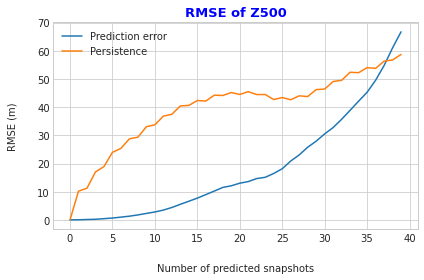

In [15]:
fig = plt.figure()
ax = plt.axes()
L=40

x = np.arange(0,int(M),1)
ax.plot(x[0:L], rmse_Z[0:L]*Zstd, label='Prediction error')
ax.plot(x[0:L], ErrorPres[0:L]*Zstd, label='Persistence')
# ax.plot(x,np.ones(len(x))*Zstd, label=f"Std of climatology={Zstd}")
ax.set_xlabel('Number of predicted snapshots', labelpad=20)
ax.set_ylabel('RMSE (m)', labelpad=20)
plt.title(f'RMSE of Z500', fontsize = 13, 
                fontweight = 'bold', color = 'b')
ax.legend()
plt.tight_layout()
plt.savefig('/home/ebrahimn/dgl/examples/pytorch/stgcn_wave/ResultsFig/RMSEplots/Z500_RMSE_'+control_str+'_lag'+str(lead)+'_lead'+str(lead2)+'_.png', format = 'png', dpi = 600)


In [16]:
40*6/24

10.0

In [17]:
autoreg_pred1=autoreg_pred[:,0,:]
autoreg_pred2=autoreg_pred[:,1,:]
del autoreg_pred
autoreg_pred1=(autoreg_pred1*Zstd)+Zmean
autoreg_pred2=(autoreg_pred2*Tstd)+Tmean

Z_truth=(y_t[0,0:M]*Zstd)+Zmean
T_truth=(y_t[1,0:M]*Tstd)+Tmean


In [18]:
np.shape(Z_truth)

(166, 1536)

In [19]:

autoreg_pred1=autoreg_pred1.reshape(np.size(autoreg_pred1, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))
autoreg_pred2=autoreg_pred2.reshape(np.size(autoreg_pred2, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))


Z_truth=Z_truth.reshape(np.size(Z_truth, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))
T_truth=T_truth.reshape(np.size(T_truth, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))

In [20]:
np.shape(autoreg_pred1)

(166, 6, 16, 16)

In [21]:
data_xr1 = xr.DataArray(autoreg_pred1, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr2 = xr.DataArray(autoreg_pred2, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr1_truth = xr.DataArray(Z_truth, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr2_truth = xr.DataArray(T_truth, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

In [22]:
from vcm.catalog import catalog
ds=data_xr1.to_dataset(name='Predicted_Z500')
ds=ds.merge(data_xr2.to_dataset(name='Predicted_Thickness'))
ds=ds.merge(data_xr1_truth.to_dataset(name='Truth_Z500'))
ds=ds.merge(data_xr2_truth.to_dataset(name='Truth_Thickness'))

grid = catalog["grid/c48"].read()
grid2=grid.sel(x=slice(1,48,coarsenInd),y=slice(1,48,coarsenInd),y_interface=slice(1,49,coarsenInd), x_interface=slice(1,49,coarsenInd))
grid2['x'] = np.arange(1, 17)
grid2['y'] = np.arange(1, 17)
grid2['x_interface'] = np.arange(1, 18)
grid2['y_interface'] = np.arange(1, 18)
common_coords = {"tile": range(6), "x": range(0,16), "y": range(0,16)}
grid2 = grid2.assign_coords(common_coords)
ds = ds.merge(grid2)

for dd in np.arange(0,100):
    fv3viz.plot_cube(ds.sel(time=dd), "Truth_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Truth @ day: {int(dd/dayInter)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    # plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Glob_Truth_'+savename +'_'+str(dd/dayInter)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
    plt.savefig('/home/ebrahimn/NearFinal_Results/TruthNorm'+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')

    fv3viz.plot_cube(ds.sel(time=dd), "Predicted_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Prediction @ day: {int(dd/dayInter)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    plt.savefig('/home/ebrahimn/NearFinal_Results/Glob_Prediction_'+savename +'_'+str(dd)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
    # plt.savefig('/home/ebrahimn/dgl/examples/pytorch/stgcn_wave/ResultsFig/'+weightFile+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')





/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout 

In [ ]:
# from vcm.catalog import catalog

# ds=data_xr1.to_dataset(name='Predicted_Z500')
# ds=ds.merge(data_xr2.to_dataset(name='Predicted_Thickness'))
# ds=ds.merge(data_xr1_truth.to_dataset(name='Truth_Z500'))
# ds=ds.merge(data_xr2_truth.to_dataset(name='Truth_Thickness'))

# grid = catalog["grid/c48"].read()
# common_coords = {"tile": range(6), "x": range(0,48,coarsenInd), "y": range(0,48,coarsenInd)}
# grid=grid.isel(x=slice(0,48,coarsenInd),y=slice(0,48,coarsenInd),y_interface=slice(0,49,coarsenInd), x_interface=slice(0,49,coarsenInd))

# grid = grid.assign_coords(common_coords)
# ds = ds.merge(grid)
# for dd in np.arange(0,100):
#     # fv3viz.plot_cube(ds.isel(time=dd), "Truth_Z500",vmax = 5850, vmin = 5600)
#     # plt.title(f'Truth @ day: {int(dd/dayInter)}', fontsize = 13, 
#     #             fontweight = 'bold', color = 'b')
#     # plt.tight_layout()
#     # # plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Glob_Truth_'+savename +'_'+str(dd/dayInter)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
#     # plt.savefig('/home/ebrahimn/dgl/examples/pytorch/stgcn_wave/ResultsFig/TruthNorm'+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')

#     fv3viz.plot_cube(ds.isel(time=dd), "Predicted_Z500",vmax = 5850, vmin = 5600)
#     plt.title(f'Prediction @ day: {int(dd/dayInter)}', fontsize = 13, 
#                 fontweight = 'bold', color = 'b')
#     plt.tight_layout()
#     plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Glob_Prediction_'+savename +'_'+str(dd)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')
#     # plt.savefig('/home/ebrahimn/dgl/examples/pytorch/stgcn_wave/ResultsFig/'+weightFile+str(dd)+'.png', format = 'png', dpi = 600, bbox_inches='tight')



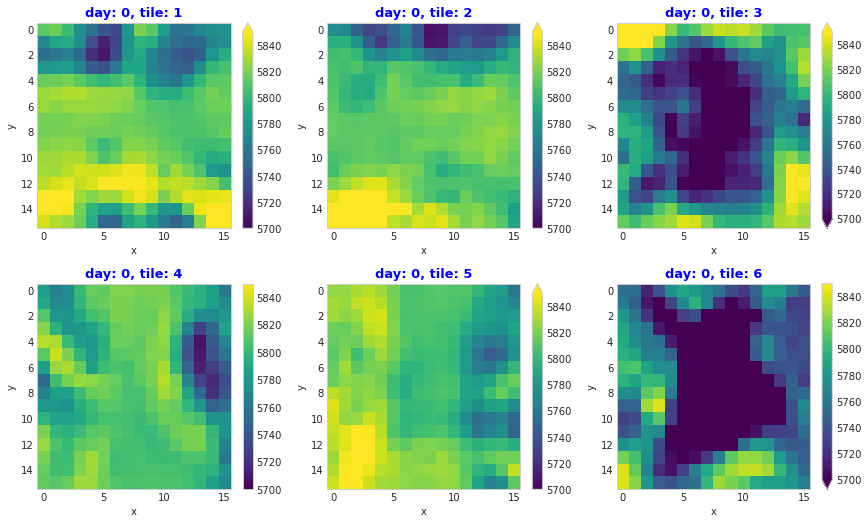

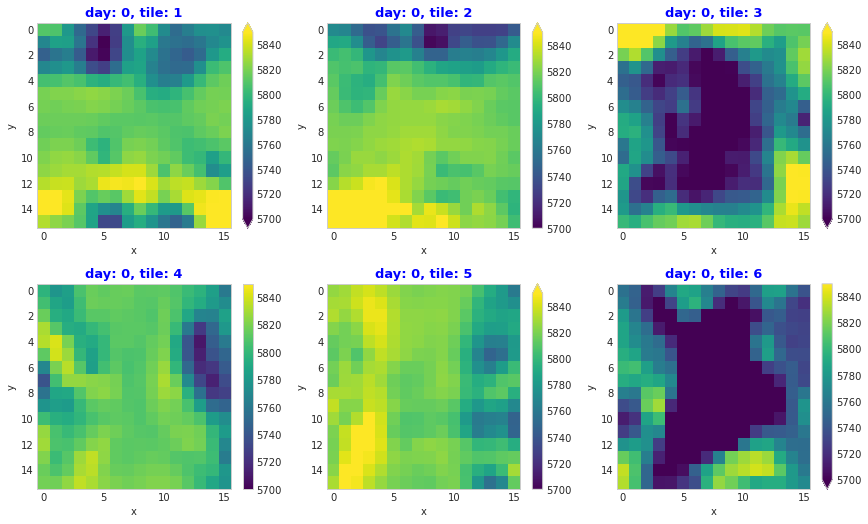

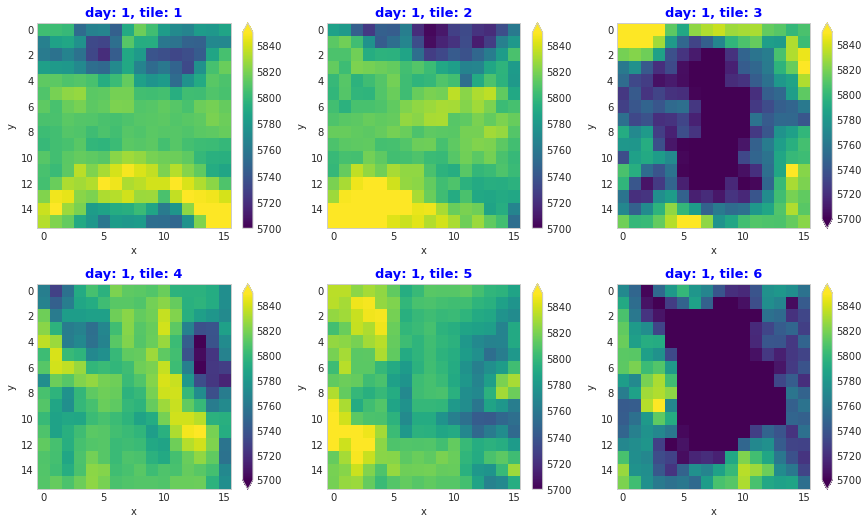

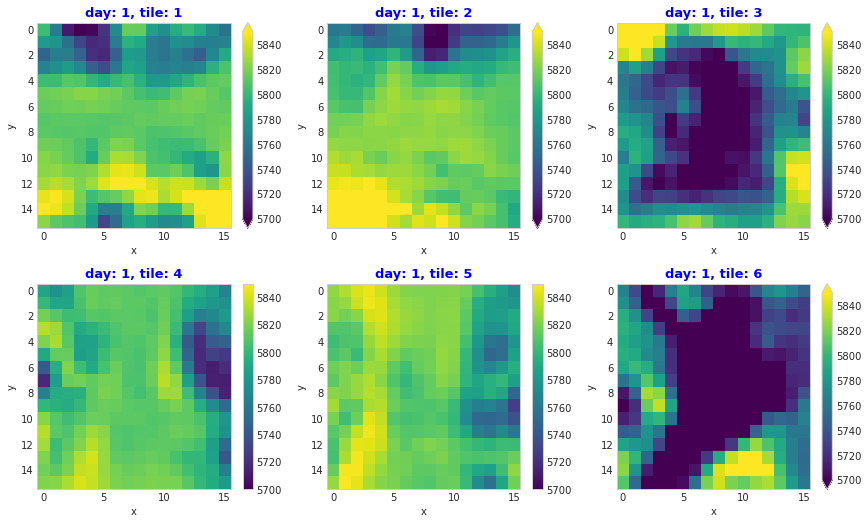

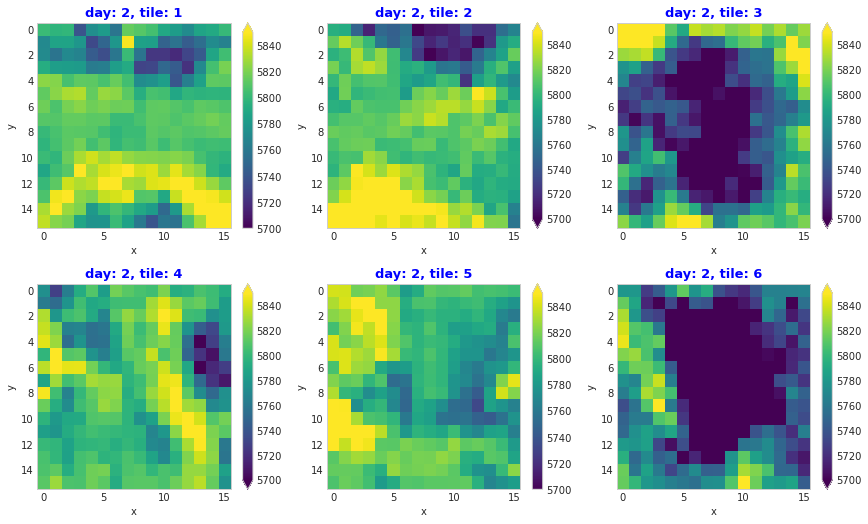

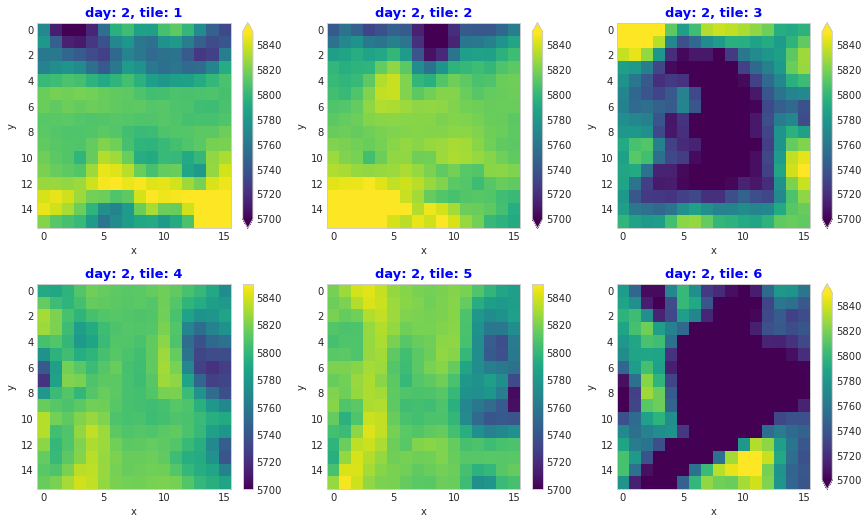

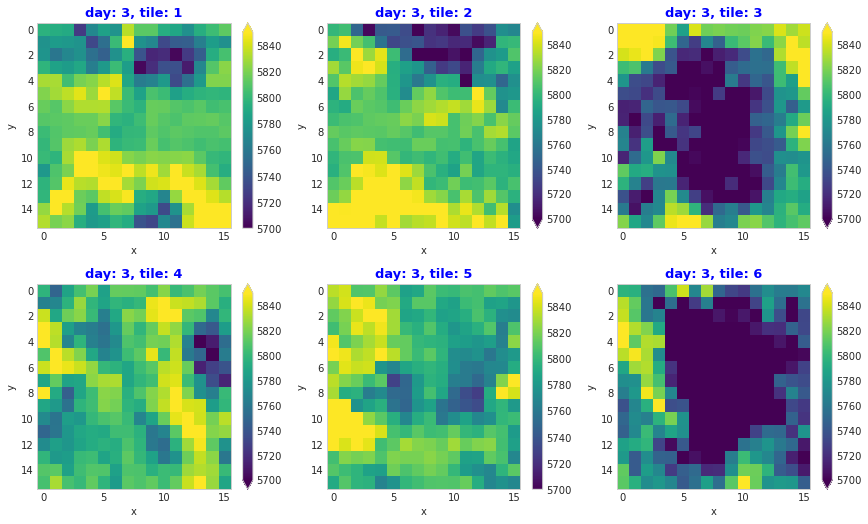

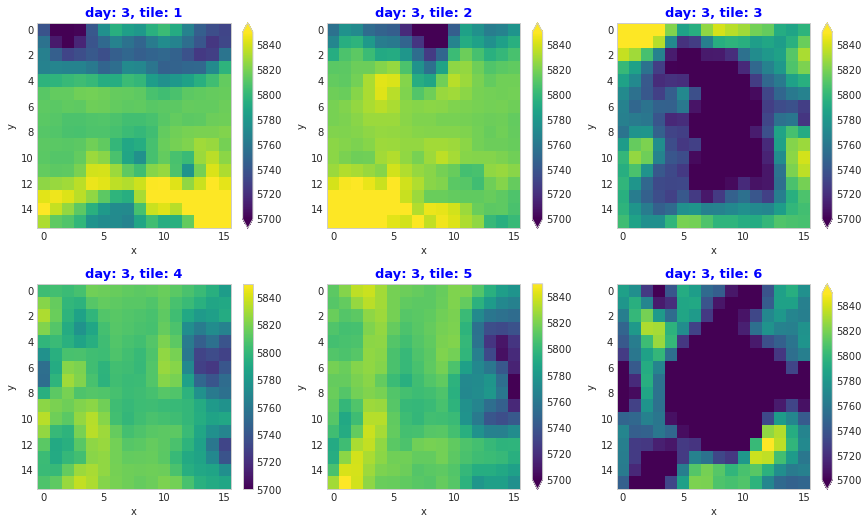

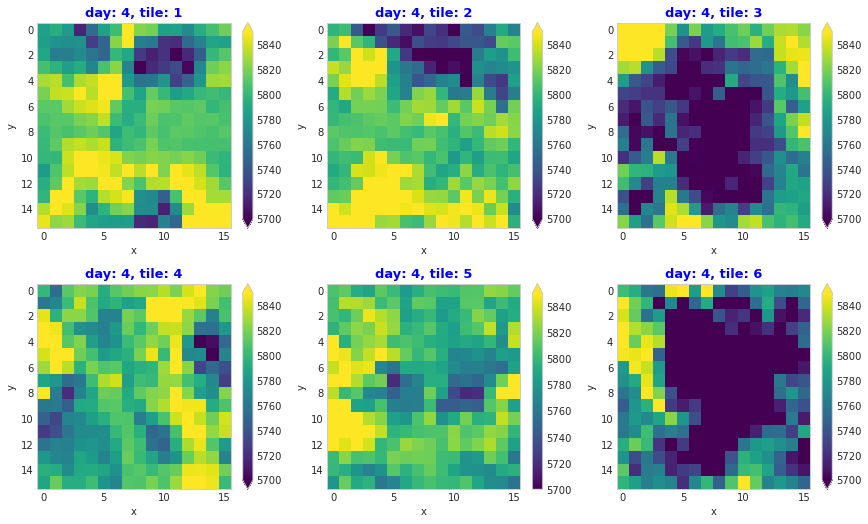

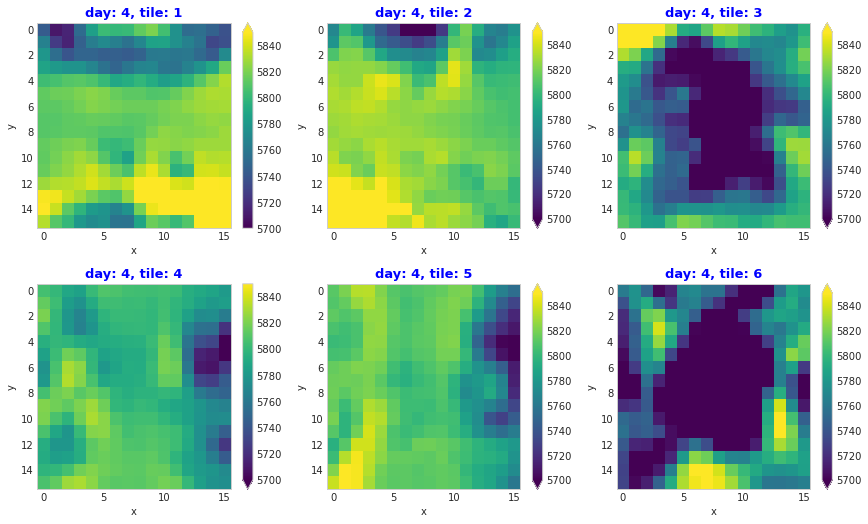

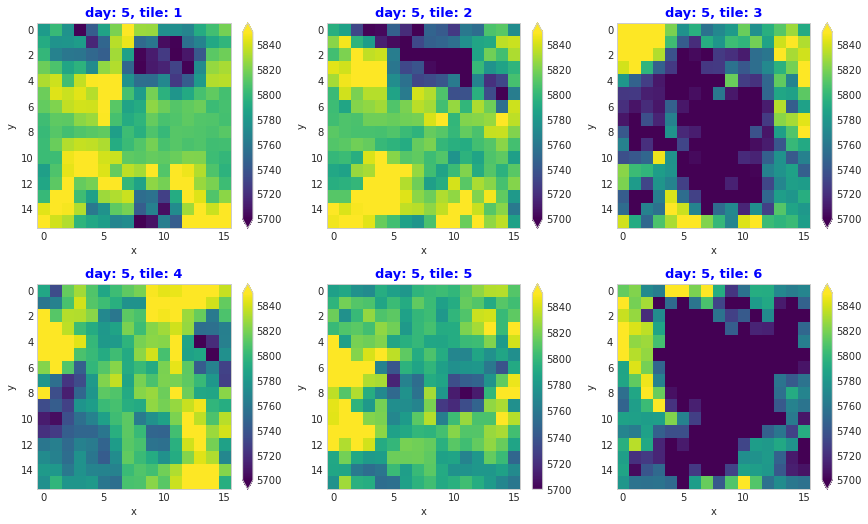

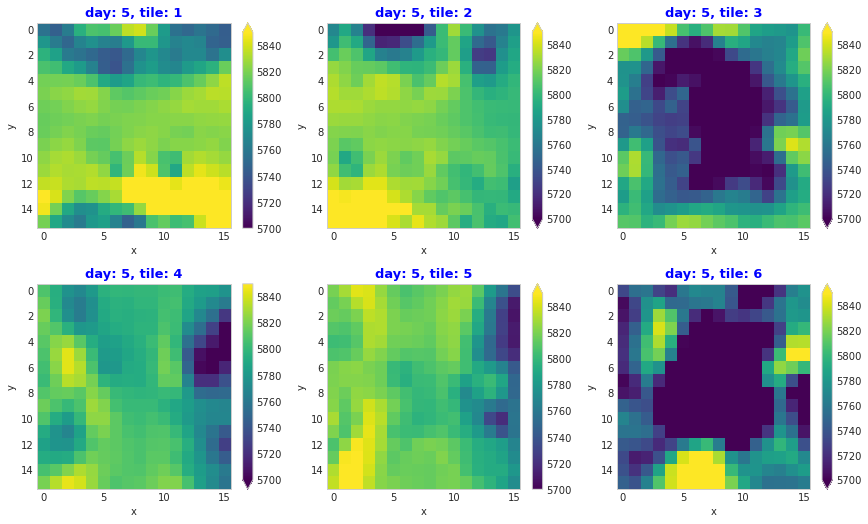

In [23]:

for timestep in np.arange(0,21,4):

    day=int(timestep*6/24)

    fig = plt.figure(figsize=[12,8], facecolor='w')
    plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                        wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
    nrows = 2
    ncols = 3
    for i in range(1, 7):
        plt.subplot(nrows, ncols, i)
        data_xr1[timestep,i-1,:,:].plot(x="x", y="y", yincrease=False,vmax = 5850, vmin = 5700)
        plt.title(f'day: {day}, tile: {i}', fontsize = 13, 
                fontweight = 'bold', color = 'b')

    # plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Prediction_'+savename +'_'+str(day)+'_.png', format = 'png', dpi = 600)

    fig = plt.figure(figsize=[12,8], facecolor='w')
    plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                        wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
    nrows = 2
    ncols = 3
    for i in range(1, 7):
        plt.subplot(nrows, ncols, i)
        data_xr1_truth[timestep,i-1,:,:].plot(x="x", y="y", yincrease=False,vmax = 5850, vmin = 5700)
        plt.title(f'day: {day}, tile: {i}', fontsize = 13, 
                fontweight = 'bold', color = 'b')

    # # plt.savefig('/home/ebrahimn/Updated_Graph_Data/Results/Truth_'+savename +'_'+str(day)+'_.png', format = 'png', dpi = 600)
